# Population Forecasting

Using an ARIMA model to forecast what the United States population will be 2 years from the dataset's most recent input.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [2]:
from pmdarima import auto_arima # for determining ARIMA orders

### Viewing first df

Our first dataset is a dataset from the U.S. Census Bureau hosted by the Federal Reserve Economic Database (FRED). This specific dataset was downloaded from Kaggle, and the link to view the database is here: https://www.kaggle.com/census/population-time-series-data

In [3]:
# loading in our first dataframe
df1 = pd.read_csv('../../../data/POP.csv')

In [4]:
df1.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


The columns within the dataframe are: realtime_start, value, date, and realtime_end. The target columns we want to focus on for our analysis will be the 'date' column and the 'value' column. We can safely drop the realtime_start and realtime_end columns.

the 'date' column within the first dataframe has a monthly frequency. 

In [5]:
df1['date'].max()

'2019-12-01'

Changing the 'date' column into a datetime object

In [6]:
df1['date'] = pd.to_datetime(df1['date'])

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
realtime_start    816 non-null object
value             816 non-null float64
date              816 non-null datetime64[ns]
realtime_end      816 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 25.6+ KB


Setting our 'date' column as the index to df1 and setting the frequency to 'MS'

In [8]:
df1.set_index('date', inplace=True)
df1.index.freq = 'MS'

In [9]:
df1.index

DatetimeIndex(['1952-01-01', '1952-02-01', '1952-03-01', '1952-04-01',
               '1952-05-01', '1952-06-01', '1952-07-01', '1952-08-01',
               '1952-09-01', '1952-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=816, freq='MS')

In [10]:
# multiplying the values in the 'value' column so they match the below dataframe
df1['value'] = df1['value'].apply(lambda x: x*1000)

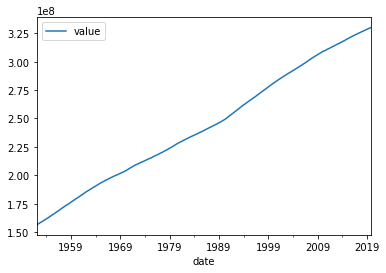

In [11]:
df1.plot()

### Viewing second df

This second dataframe contains data ranging back from 1900. Because the first dataframe only ranges from 1952 - 2019, we will concatenate the dataframes together, and then train a model to forecast the population growth over a certain amount of years.

In [12]:
df2 = pd.read_csv('../../../data/POPH.csv')

In [13]:
df2.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,76094000,1900-01-01,2019-12-06
1,2019-12-06,77584000,1901-01-01,2019-12-06
2,2019-12-06,79163000,1902-01-01,2019-12-06
3,2019-12-06,80632000,1903-01-01,2019-12-06
4,2019-12-06,82166000,1904-01-01,2019-12-06


Unlike our first dataframe, it seems that the 'date' column within our second dataframe has a frequency in years. In order to make sure that the frequency remains the same once both dataframes are concatenated, we must resample this dataframe and then forward fill the newly created month columns to ensure no data is lost and there are no null values within the dataframe.

Changing the 'date' column into a datetime object

In [14]:
df2['date'] = pd.to_datetime(df2['date'])

Setting the 'date' column as the df2 index, and then setting the frequency into Years. Above, we can see that each date under the date column is at the beginning of each year. So we will make sure to use 'AS' to signify that it is the start of the year.

In [15]:
df2.set_index('date', inplace=True)
df2.index.freq = 'AS'

Now that we've set the frequency, we will resample the index to equal the same frequency as df1 ('MS'). We will call ffill() to have each newly created row in 'value' propagate the last valid observation forward.

In [16]:
df2 = df2.resample('MS').ffill()

We will cut off df2 at the end of 1951, since df1 begins at 1952.

In [17]:
df2 = df2.loc[:'1951-12-01']

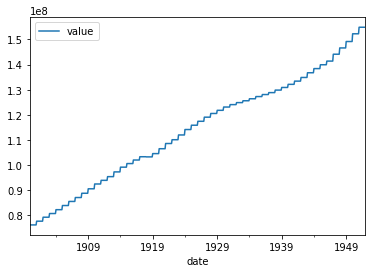

In [18]:
df2.plot()

### Merging dfs

In [19]:
pop_df = df2.reset_index().merge(df1.reset_index(), how = 'outer').set_index('date')

C:\Users\Lewis\anaconda3\envs\learn-env\lib\site-packages\pandas\core\reshape\merge.py:1100: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [20]:
pop_df.isna().sum()

realtime_start    0
value             0
realtime_end      0
dtype: int64

In [21]:
pop_df.index

DatetimeIndex(['1900-01-01', '1900-02-01', '1900-03-01', '1900-04-01',
               '1900-05-01', '1900-06-01', '1900-07-01', '1900-08-01',
               '1900-09-01', '1900-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=1440, freq=None)

In [22]:
pop_df.index.freq = 'MS'

In [23]:
pop_df.head()

,realtime_start,value,realtime_end
date,,,
1900-01-01,2019-12-06,76094000.0,2019-12-06
1900-02-01,2019-12-06,76094000.0,2019-12-06
1900-03-01,2019-12-06,76094000.0,2019-12-06
1900-04-01,2019-12-06,76094000.0,2019-12-06
1900-05-01,2019-12-06,76094000.0,2019-12-06


We don't need the realtime start and realtime end columns, so we will drop these from our dataframe

In [24]:
pop_df.drop(columns=['realtime_start', 'realtime_end'], inplace=True)

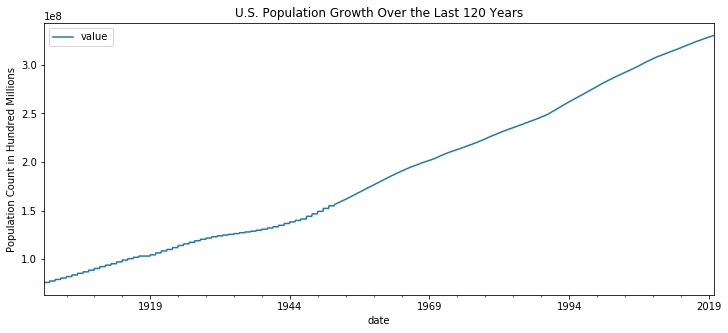

In [25]:
ax = pop_df.plot(figsize=(12,5))
ax.set_ylabel('Population Count in Hundred Millions')
ax.set_title('U.S. Population Growth Over the Last 120 Years');

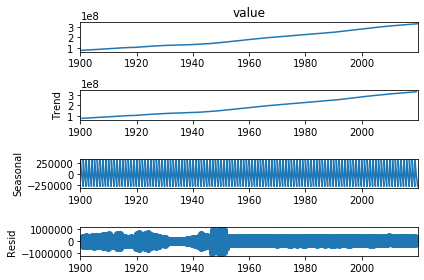

In [26]:
seasonal = seasonal_decompose(pop_df['value'], model='add')
seasonal.plot();

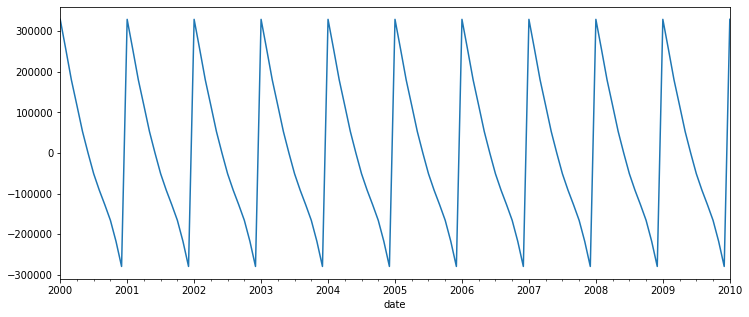

In [32]:
seasonal.seasonal.loc['2000-01-01':'2010-01-01'].plot(figsize=(12,5))

In [6]:
def adfuller_report(series):
    """
    Definition:
    Uses the Dickey-Fuller Test to determine if a series is stationary
    
    Args:
    Series: Required. A series to test stationarity on.
    
    Returns:
    Whether or not the null hypothesis is rejected (the series is non-stationary)
    """
    
    values = adfuller(series.dropna(), autolag='AIC')
    tags = ['Test Statistic', 'P-value', 'Used_lag', 'num_obs']
    
    output = pd.Series(values[0:4],index=tags)
    
    if output['P-value'] <= 0.05:
        print('Reject the null hypothesis. \nSeries is stationary.')
    else:
        print('Failed to reject null hypothesis. \nSeries is non-stationary.') 

In [34]:
test = adfuller_report(pop_df['value'])

Failed to reject null hypothesis. 
Series is non-stationary.


the auto_arima library is extremely useful - it analyzes the series and determines the "best" model for us to use in order to forecast predictions on our dataset. Instead of having to manually plot the ACF and the PACF in order to determine the order, the auto_arima library will spit out a suggested model based on what information we feed into it.

In [35]:
auto_arima(pop_df['value'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1440
Model:             SARIMAX(1, 2, 0)x(2, 0, 0, 12)   Log Likelihood              -20620.907
Date:                            Sun, 21 Mar 2021   AIC                          41249.815
Time:                                    17:08:59   BIC                          41270.899
Sample:                                         0   HQIC                         41257.686
                                           - 1440                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.001    -16.057      0.000      -0.022      -0.018
ar.S.L12       0.0376      0.001     42.498      0.000       0.036       0.039
ar.S.L24       0.0389      0.001     41.006      0.000       0.037       0.041
sigma2      1.457e+11   5.55e-17   2.63e+27      0.000    1.46e+11    1.46e+11
===================================================================================
Ljung-Box (L1) (Q):                 339.14   Jarque-Bera (JB):             18271.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+41. Standard errors may be unstable.
"""

### Splitting into train and test sets

In [37]:
# Giving our test set 24 months (2 years) worth of data
nobs = 24

train = pop_df[:-nobs]
test = pop_df[-nobs:]

Fitting SARIMA model to training data

In [38]:
model = SARIMAX(train['value'],order=(1,2,0), seasonal_order=(2,0,0,12))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                 1416
Model:             SARIMAX(1, 2, 0)x(2, 0, 0, 12)   Log Likelihood              -20288.638
Date:                            Sun, 21 Mar 2021   AIC                          40585.277
Time:                                    17:09:13   BIC                          40606.293
Sample:                                01-01-1900   HQIC                         40593.129
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.001    -15.789      0.000      -0.022      -0.018
ar.S.L12       0.0376      0.001     41.788      0.000       0.036       0.039
ar.S.L24       0.0389      0.001     40.323      0.000       0.037       0.041
sigma2      1.481e+11   5.55e-17   2.67e+27      0.000    1.48e+11    1.48e+11
===================================================================================
Ljung-Box (L1) (Q):                 333.51   Jarque-Bera (JB):             17272.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+41. Standard errors may be unstable.
"""

In [39]:
start = len(train)
end = len(train) + len(test) - 1
y_pred = fit_model.predict(start, end, typ='levels').rename('SARIMA(1,2,0)(2,0,0,12) Prediction')

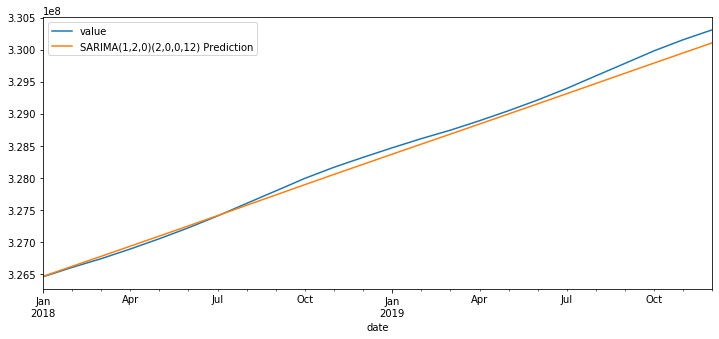

In [40]:
test.plot(figsize=(12,5), legend=True)
y_pred.plot(legend=True)

In [41]:
mse = mean_squared_error(test['value'], y_pred)
root_mse = rmse(test['value'], y_pred)
print(f"Mean Squared Error: {mse}\nRoot Mean Squared Error: {root_mse}")

Mean Squared Error: 9983876114.406385
Root Mean Squared Error: 99919.3480483454


In [44]:
test.std().astype('int')

value    1188989
dtype: int32

# Predicting into the Future

In [45]:
model = SARIMAX(pop_df['value'],order=(1,2,0), seasonal_order=(2,0,0,12))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                 1440
Model:             SARIMAX(1, 2, 0)x(2, 0, 0, 12)   Log Likelihood              -20620.907
Date:                            Sun, 21 Mar 2021   AIC                          41249.815
Time:                                    17:11:25   BIC                          41270.899
Sample:                                01-01-1900   HQIC                         41257.686
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.001    -16.057      0.000      -0.022      -0.018
ar.S.L12       0.0376      0.001     42.498      0.000       0.036       0.039
ar.S.L24       0.0389      0.001     41.006      0.000       0.037       0.041
sigma2      1.457e+11   5.55e-17   2.63e+27      0.000    1.46e+11    1.46e+11
===================================================================================
Ljung-Box (L1) (Q):                 339.14   Jarque-Bera (JB):             18271.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+41. Standard errors may be unstable.
"""

In [54]:
# Feel free to change the variable NUM_MONTHS to predict however many months
# into the future. Must be a positive integer

NUM_MONTHS = 35

start = len(pop_df)
end = len(pop_df) + NUM_MONTHS
forecast = fit_model.predict(start, end, typ='levels').rename('SARIMA(1,2,0)(2,0,0,12) Forecast')

In [55]:
forecast.head()

2020-01-01    3.304648e+08
2020-02-01    3.306192e+08
2020-03-01    3.307728e+08
2020-04-01    3.309275e+08
2020-05-01    3.310830e+08
Freq: MS, Name: SARIMA(1,2,0)(2,0,0,12) Forecast, dtype: float64

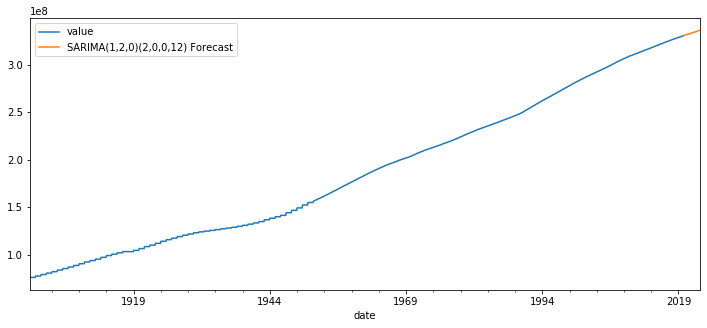

In [56]:
pop_df.plot(figsize=(12,5), legend=True)
forecast.plot(legend=True);